# Overview

This week's curriculum is a little bit of a mixed bag. We'll cover 3 topics that are not super-related, but all are _very useful_ (and there is some connection between them). The overview is

* Tricks for raw text (chapter 3)
* Finding the important words in a document (TF-IDF)
* Sentiment analysis.

In the first part, we will take a quick tour of NLPP1e's chapter 3, which is boring, but an amazing ressource that you'll keep returning to. Then we'll talk about how we can use simple statistics & machine learning to get text to show us what it's all about. We will even do a little visualization. Finally, we'll jump to _sentiment analysis_. A topic which is pretty useless when it comes to wikipedia (because all wikipedia text is designed to be neutral), but which is highly useful elsewhere as we shall see (and since the course is all about teaching you stuff that's useful for the project and the rest of your lives, I'll get into it here. 

# Processing real text (from out on the inter-webs)

Ok. So Chapter 3 in NLPP1e is all about working with text from the real world. Getting text from this internet, cleaning it, tokenizing, modifying (e.g. stemming, converting to lower case, etc) to get the text in shape to work with the NLTK tools you've already learned about - and many more. In the process we'll learn more about regular expressions, as well as unicode; something we've already been struggling with a little bit will now be explained in more detail. 
> 
> **Video lecture**: Short overview of chapter 3 + a few words about kinds of language processing that we don't address in this class. 
> 

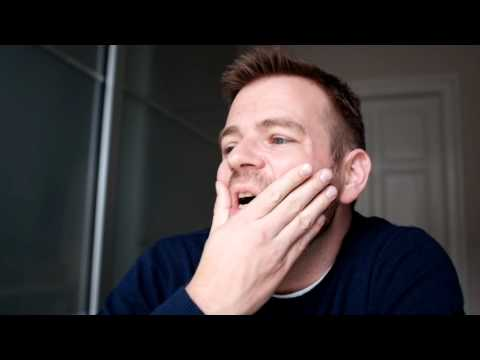

In [29]:
from IPython.display import YouTubeVideo
YouTubeVideo("Rwakh-HXPJk",width=800, height=450)

> _Reading_: NLPP Chapter 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.9, and 3.10\. It's not important that you go in depth with everything here - the key think is that you _know that Chapter 3 of this book exists_, and that it's a great place to return to if you're ever in need of an explanation of regular expressions, unicode, or other topics that you forget as soon as you stop using them (and don't worry, I forget about those things too).
> 

In [32]:
# import all necessary packages
from bs4 import BeautifulSoup
from collections import Counter
import cStringIO
from __future__ import division
import itertools
import json
import math
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import numpy as np
import os
import operator
import pandas as pd
import pickle
import pprint
import random
import re
import requests
from scipy.misc import imread
import urllib
# sudo -H pip install wordcloud
from wordcloud import WordCloud

# IPython specifics
%matplotlib inline

# specify nltk data dir, otherwise LookupError error
nltk.data.path.append(os.getcwd() + '/../nltk_data')

# create dir if not exists
directory = 'philosophers'
if not os.path.exists(directory):
    os.makedirs(directory)

> _Exercise_: Just a couple of examples from the book: Work through the exercises NLPP1e 3.12: 6, 30\.
> 

Describe the class of strings matched by the following regular expressions. Test your answers using nltk.re_show().

a. `[a-zA-Z]+`

In [6]:
# regex matches consecutive ([]) lower (a-z) and uppercase letters (A-Z) (+ = minimum 1 or more)
nltk.re_show(r'[a-zA-Z]+', 'shit,6this8.*+issilly666yep.y.')

{shit},6{this}8.*+{issilly}666{yep}.{y}.


b. `[A-Z][a-z]*`

In [7]:
# regex matches one uppercase letter ([A-Z]) followed by none or more lower case letters ([a-z]*)
nltk.re_show(r'[A-Z][a-z]*', 'Shit,6This.*+.IsSilly666YYyY')

{Shit},6{This}.*+.{Is}{Silly}666{Y}{Yy}{Y}


c. `p[aeiou]{,2}t`

In [8]:
# regex matches start with character 'p' followed by two or less characters of a,e,i,o,u and the last character is t
nltk.re_show(r'p[aeiou]{,2}t', '1.pat-2.paut-3.paeut-Papa')

1.{pat}-2.{paut}-3.paeut-Papa


d. `\d+(\.\d+)?`

In [9]:
# regex matches minimum 1 or more (+) digits (\d is equivalent to set [0-9]) 
# and after a dot (.) followed by minimum 1 or more (+) digits (\d) 
# the last repetition is matched one or zero times (?)
nltk.re_show(r'\d+(\.\d+)?', '000.0a123.4.44..3.3.3.3.33.33.33.333.333')

{000.0}a{123.4}.{44}..{3.3}.{3.3}.{33.33}.{33.333}.{333}


e. `([^aeiou][aeiou][^aeiou])*`

In [10]:
# regex matches set of three charcter ([][][])* each set zero to unlimited times
# single character not in a,e,i,o,u ([^aeiou]) followed by character in a,e,i,o,u ([aeiou]) 
# and ends with character not in a,e,i,o,u
nltk.re_show(r'([^aeiou][aeiou][^aeiou])*', 'tantrum tantrumaiouAiotant')

{tan}t{rum} {tan}t{rum}a{}i{}o{}u{}A{}i{}o{tan}t{}


f. `\w+|[^\w\s]+`

In [11]:
# regex matches any word character (\w+) (also: [a-zA-Z0-9_]) between one to unlimited times
# or (|) set of characters with no word character ([^\w]) or not any white space character ([^\s]) (also: \r\n\t\f) inside
nltk.re_show(r'\w+|[^\w\s]+', 'fe0_8a\rfe80q#*###e$\te*$#\t#$www.\nnoooo')

{fe80q}{#*###}{e}{$}	{e}{*$#}	{#$}{www}{.}
{noooo}


Use the Porter Stemmer to normalize some tokenized text, calling the stemmer on each word. Do the same thing with the Lancaster Stemmer, and see if you observe any differences.

In [2]:
raw = """
So close no matter how far
Couldn't be much more from the heart
Forever trusting who we are
And nothing else matters
"""
tokens = nltk.word_tokenize(raw)

porter = nltk.PorterStemmer()
lancaster = nltk.LancasterStemmer()

print "tokens", tokens
port = [porter.stem(t) for t in tokens]
print "\nporter stemmer result", port
lan = [lancaster.stem(t) for t in tokens]
print "\nlancaster stemmer result", lan
print "\ndifferences", list(set(port) - set(lan))

NameError: name 'nltk' is not defined

The Porter and Lancaster stemmers follow their own rules for stripping affixes. Diffferences are that the Lancaster stemmer is not lowercasing words and it also seems more aggressive. further explanations at: http://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg

# Words that characterize the branches

In this section, we'll begin to play around with how far we can get with simple strategies for looking at text. The video is basically just me talking about a fun paper, which shows you how little is needed in order to reveal something very interesting about humans that produce text. Then, in the exercise (which is the main work you'll do today), we'll use a very simple weighting scheme called TF-IDF to find the important words within each branch of philosophy (according to wikipedia). In cleaning the wiki pages, we'll use some of the stuff you've just read about above. Finally, we'll even visualize them in a fun little word cloud (below is what I found for metaphysics).

![Metaphysics](https://raw.githubusercontent.com/suneman/socialgraphs2016/master/files/List_of_metaphysicians.png)

> **Video lecture**: Simple methods reveal a lot. I talk a little bit about the paper: [Personality, Gender, and Age in the Language of Social Media: The Open-Vocabulary Approach](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0073791).  

In [28]:
YouTubeVideo("wkYvdfkVmlI",width=800, height=450)

NameError: name 'YouTubeVideo' is not defined

 _Exercises_: TF-IDF and the branches of philosophy.
> 
> Setup. We want to start from a clean version of the philosopher pages with as little wiki-markup as possible. 
> We needed it earlier to get the links, etc, but now we want a readable version. We can get a fairly nice version directly
> from the wikipedia API, simply call `prop=extracts&exlimit=max&explaintext` instead of `prop=revisions` as we did earlier.
> This will make the API return the text without links and other markup. 
> 
> * Use this method to retrive a nice copy of all philosopher's text. You can, of course, also clean the existing pages using
> regular expressions, if you like (but that's probably more work).
> 

In [38]:
# rebuild a current list
phil_links = [
    ('https://en.wikipedia.org/w/index.php?title=List_of_aestheticians&action=edit', 'aestheticians'),
    ('https://en.wikipedia.org/w/index.php?title=List_of_epistemologists&action=edit', 'epistemologists'),
    ('https://en.wikipedia.org/w/index.php?title=List_of_ethicists&action=edit', 'ethicists'),
    ('https://en.wikipedia.org/w/index.php?title=List_of_logicians&action=edit', 'logicians'),
    ('https://en.wikipedia.org/w/index.php?title=List_of_metaphysicians&action=edit', 'metaphysicians'),
    ('https://en.wikipedia.org/w/index.php?title=List_of_social_and_political_philosophers&action=edit', 'social_and_political_philosophers')
]

# get all philosopher pages wiki text
all_matches = {
    'all': set()
}
for l in phil_links:
    r = requests.get(l[0])
    soup = BeautifulSoup(r.text, 'html.parser')
    wiki_text = soup.find('textarea').get_text()
    # lines of philosophers start with "*" or "*St."
    # this link in logicians '[[Categoriae decem]]'' wasn't counted
    matches = re.findall(r'(\*\s?|\*\s?St\.\s?)\[\[(.+?)\]\]', wiki_text)
    # only 2nd group with philosopher name
    # remove any lists that can occur in the == See also == section
    m = [x[1].split('|')[0].replace(' ', '_') for x in matches if not re.match(r'list of.*', x[1], re.IGNORECASE)]
    # put in dictonary
    all_matches[l[1]] = m
    all_matches['all'] |= set(m)

pprint.pprint(all_matches)

# store philosopher categories in one small binary file
with open('{0}/cat.pkl'.format(directory), 'wb') as f:
    pickle.dump(all_matches, f)

{'aestheticians': [u'Andreas_Linder',
                   u'Virgil_Aldrich',
                   u'Anandavardhana',
                   u'Sri_Aurobindo',
                   u'John_Anderson_(philosopher)',
                   u'Yves_Marie_Andr\xe9',
                   u'Thomas_Aquinas',
                   u'Aristotle',
                   u'Rudolf_Arnheim',
                   u'Mazen_Asfour',
                   u'Georg_Anton_Friedrich_Ast',
                   u'Augustine_of_Hippo',
                   u'Jody_Azzouni',
                   u'Victor_Basch',
                   u'Yusuf_Balasagun',
                   u'Roland_Barthes',
                   u'Georges_Bataille',
                   u'Alexander_Gottlieb_Baumgarten',
                   u'Monroe_Beardsley',
                   u'Vissarion_Belinsky',
                   u'Clive_Bell',
                   u'Walter_Benjamin',
                   u'Arnold_Berleant',
                   u'George_Birkhoff',
                   u'Max_Black',
           

In [18]:
# wikipedia API parameters: https://en.wikipedia.org/w/api.php?action=help&modules=parse
baseurl = "https://en.wikipedia.org/w/api.php"
action = "action=query"
content = "prop=extracts&exlimit=max&explaintext"
dataformat = "format=json"

# get content key: philosopher name, value: json
data = dict()
for p_name in all_matches['all']:
    # replace special cahrs in philosopher name with URL encoded
    title = 'titles={0}'.format(urllib.quote(p_name.encode('utf-8')))
    # concatenate wikipedia query
    url = '{0}?{1}&{2}&{3}&{4}'.format(baseurl, action, title, content, dataformat)
    r = requests.get(url)
    try:
        json_object = json.loads(r.text)
        data.update({p_name:json_object})
    except ValueError:
        print 'No valid json returned for', p_name, 'link:', url

No json returned for Onora_O'Neill,_Baroness_O'Neill_of_Bengarve link: https://en.wikipedia.org/w/api.php?action=query&titles=Onora_O%27Neill%2C_Baroness_O%27Neill_of_Bengarve&prop=extracts&exlimit=max&explaintext&format=json


In [19]:
# store philosopher data in one small binary file
with open('{0}/dat_plaintext.pkl'.format(directory), 'wb') as f:
    pickle.dump(data, f)

> The exercise.
> 
> * First, check out [the wikipedia page for TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). Explain in your own words the point of TF-IDF. 


TF-IDF is a simple weighting scheme to find important words within a category. These can be visualized in word or tag clouds where words with higher tf–idf value appear bigger and thus are more important in the document.

>   * What does TF stand for? 

Term frequency - The number of times a term (= word) occurs in a document. A higher weight (more importance) is put on a word that occurs frequently.

>   * What does IDF stand for?


Inverse document frequency - Puts a weight on all terms depending on how often it appears in the whole document (all philosophy branches). Those words occurring very frequently in the document get a lower weight (e.g.: the) than terms that occur rarely (like proper nouns appearing in a single document/branch).

> * Since we want to find out which words are important for each _branch_, so we're going to create six large documents, one per branch of philosophy. Tokenize the pages, and combine the tokens into one long list per branch. Remember the bullets below for success.
>   * If you dont' know what _tokenization_ means, go back and read Chapter 3 again. This advice is valid for every cleaning step below.


In [4]:
# get data dictionary
with open('{0}/dat_plaintext.pkl'.format(directory), 'rb') as f:
    phil_plaintext = pickle.load(f)
    
# get category dictionary data
with open('{0}/cat.pkl'.format(directory), 'rb') as f:
    cat = pickle.load(f)
# key all not needed
del cat['all']

>   * Exclude punctuation.
>   * Exclude numbers (since they're difficult to interpret in the word cloud).

In [5]:
# tokenizer to remove punctuation and exclude numbers
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

# generate new dict with key: branch and value: wiki text from all philosophers in that branch
phil_texts = dict()
for branch in cat:
    phil_texts[branch] = list()
    for phil in cat[branch]:
        if phil in phil_plaintext:
            # wiki entry contains excerpt with unknown pageid
            try:
                for page in phil_plaintext[phil]['query']['pages']:
                    # -1 returned for no matches, e.g.: Andreas_Linder in list of aestheticians
                    if page != '-1':
                        text = phil_plaintext[phil]['query']['pages'][page]['extract']
                        # tokenize, other method is to use text.split()
                        tokens = tokenizer.tokenize(text)
                        # concatenate the lists, text is list
                        phil_texts[branch] = phil_texts[branch] + tokens
            except KeyError:
                # Martinus Dorpius only in Dutch wikipedia
                print "Key error on:", branch, phil
                
print 'excerpt aestheticians tokens:', phil_texts['aestheticians'][0:10], len(phil_texts['aestheticians'])

Key error on: logicians :nl:Martinus_Dorpius
excerpt aestheticians tokens: [u'Virgil', u'Charles', u'Aldrich', u'September', u'Narsinghpur', u'India', u'May', u'Salt', u'Lake', u'City'] 367681


>   * Exclude philosopher names (since we're interested in the words, not the names).

In [6]:
# load names in general
m = names.words('male.txt')
f = names.words('female.txt')
general_names = m + f

# split all the names and exclude extensions like "(logician)"
p_names = [x.split('_') for x in phil_plaintext.keys() if '(' not in x]
# merge list of lists
p_names = set(itertools.chain.from_iterable(p_names + general_names))
print 'name list for replacement:', list(p_names)[0:6]

name list for replacement: [u'Andreas', u'Corbin', u'Lucretius', u'Makinson', u'Mortimer', u'Sinope']


In [7]:
# replace the names
for k, v in phil_texts.iteritems():
    phil_texts[k] = [w for w in v if w not in p_names]
    
print phil_texts['aestheticians'][0:10], len(phil_texts['aestheticians'])

[u'September', u'Narsinghpur', u'India', u'Salt', u'Lake', u'City', u'Utah', u'was', u'an', u'American'] 286310


>   * Exclude stop words (if you don't know what stop words are, go back and read NLPP1e again).
>   * Set everything to lower case.

In [8]:
# load english stop words
stopwords = nltk.corpus.stopwords.words('english')

# replace the stopwords and set all alphabetic words to lower case
for k, v in phil_texts.iteritems():
    phil_texts[k] = [w.lower() for w in v if w not in stopwords and w.isalpha()]

print phil_texts['aestheticians'][0:10], len(phil_texts['aestheticians'])

[u'september', u'narsinghpur', u'india', u'salt', u'lake', u'city', u'utah', u'american', u'philosopher', u'art'] 199290


>   * Note that none of the above has to be perfect. It might not be easy to remove _all_ philosopher names. And there's some room for improvisation. You can try using stemming. In my own first run the results didn't look so nice, because some pages are very detailed and repeat certain words again and again and again, whereas other pages are very short. For that reason, I decided to use the unique set of words from each page rather than each word in proportion to how it's actually used on that page. Choices like that are up to you.

In [9]:
# create a WordNetLemmatizer for stemming the tokens
wl = WordNetLemmatizer() 

# disregard words that are less than 2 letters in length
for k, v in phil_texts.iteritems():
    phil_texts[k] = [wl.lemmatize(w) for w in v if len(w) > 2]

print phil_texts['aestheticians'][0:10], len(phil_texts['aestheticians'])

[u'september', u'narsinghpur', u'india', u'salt', u'lake', u'city', u'utah', u'american', u'philosopher', u'art'] 192379


> * Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within each branch. 
>   * Describe similarities and differences between the branches.
>   * Why aren't the TFs not necessarily a good description of the branches?

In [10]:
# var to save results
phil_weighted = dict()

for k, text in phil_texts.iteritems():
    # create same structure for each branch
    phil_weighted[k] = {
        'tf': dict(), 
        'idf': dict(),
        'tf-idf': dict(),
        # scaled value needed later for wordcloud
        'tf-idf_scaled': dict()
    }
    
    # compute number of times a word appears in a document
    phil_weighted[k]['w_freq'] = Counter(text)
    # get number of words in each document/branch
    phil_weighted[k]['w_len'] = len(text)
    phil_weighted[k]['w_set'] = set(text)
    # compute TF for each token
    for token in phil_weighted[k]['w_set']:
        phil_weighted[k]['tf'][token] = phil_weighted[k]['w_freq'][token] / phil_weighted[k]['w_len']

In [11]:
for branch in phil_weighted:
    print "frequent words in branch", branch
    print sorted(phil_weighted[branch]['tf'].items(), key=operator.itemgetter(1), reverse=True)[0:10]
    print "\n"

frequent words in branch aestheticians
[(u'the', 0.015531840793433794), (u'work', 0.008483254409265045), (u'philosophy', 0.006284469718628332), (u'one', 0.0051668841193685386), (u'university', 0.005135695684040358), (u'art', 0.004631482646234776), (u'also', 0.004148061898647981), (u'first', 0.0037686026021551207), (u'life', 0.0035346893371937687), (u'new', 0.0034983028293108917)]


frequent words in branch logicians
[(u'the', 0.012194759816682669), (u'logic', 0.011031704395854573), (u'university', 0.008166133805814288), (u'philosophy', 0.007428707177289239), (u'work', 0.007102061825056668), (u'theory', 0.005919209716214477), (u'also', 0.004810595187425144), (u'one', 0.0047710018113969535), (u'mathematics', 0.004488899007196096), (u'first', 0.003771269066685144)]


frequent words in branch epistemologists
[(u'the', 0.012544538246717812), (u'philosophy', 0.008101948447982538), (u'work', 0.006002632170256476), (u'university', 0.005681635797515488), (u'one', 0.0055981767406028315), (u'also

The five most popular words in each branch are almost similar (work, philosophy, university, one ...) because those words occur in each document very frequently. The biggest difference is that the headline of each branch sticks out. In the branch "logicians" it's logic in "social_and_political" it's political and law other than that they are rather similar.

The TFs are not really a good indicator of how important the word is just how often it occurs. Each and every philosopher went to university which is why the word often occurs but is too general. Extracting branch-specific words will give more valuable results.

> * Next, we calculate IDF for every word. 
>   * What base logarithm did you use? Is that important?

In [12]:
# compute number of documents containing a particular word
num_docs_containing = Counter()
for k, text in phil_texts.iteritems():
    # convert text to set for fast lookup
    for token in phil_weighted[k]['w_set']:
        # increase the count for each word
        num_docs_containing[token] += 1
        
print "docs containing work vs. homomorphism:", num_docs_containing['work'], "to", num_docs_containing['homomorphism']

# compute IDF
total_docs = len(phil_texts.keys())
for k, text in phil_texts.iteritems():    
    for token in phil_weighted[k]['w_set']:        
        # the Inverse-Document-Frequency
        phil_weighted[k]['idf'][token] = math.log(
            total_docs / num_docs_containing[token])

docs containing work vs. homomorphism: 6 to 1


In [13]:
for branch in phil_weighted:
    print "frequent words across documents in branch", branch
    print sorted(phil_weighted[branch]['idf'].items(), key=operator.itemgetter(1), reverse=True)[0:3]
    print "\n"

frequent words across documents in branch aestheticians
[(u'sprague', 1.791759469228055), (u'schlegelschen', 1.791759469228055), (u'screaming', 1.791759469228055)]


frequent words across documents in branch logicians
[(u'homomorphism', 1.791759469228055), (u'logices', 1.791759469228055), (u'isaim', 1.791759469228055)]


frequent words across documents in branch epistemologists
[(u'nissim', 1.791759469228055), (u'sanderson', 1.791759469228055), (u'arbitrage', 1.791759469228055)]


frequent words across documents in branch ethicists
[(u'deferment', 1.791759469228055), (u'sowell', 1.791759469228055), (u'trawling', 1.791759469228055)]


frequent words across documents in branch metaphysicians
[(u'clottes', 1.791759469228055), (u'fous', 1.791759469228055), (u'towarzystwo', 1.791759469228055)]


frequent words across documents in branch social_and_political_philosophers
[(u'epimeteo', 1.791759469228055), (u'woody', 1.791759469228055), (u'regularize', 1.791759469228055)]




We take the ratio of the total number of documents (6 branches) to the number of documents containing word, then take the log of that. The python `math.log(x)` function returns the natural logarithm of $x$ to base $e$. But the precise base of the logarithm is not material to ranking. The values may change with another base but because it is applied to all values it won't change the final order the log of one (when equal number of total documents and number of documents containing the word) will also stay zero. Adding log is to dampen the importance of term that has a high frequency. If the tf in branch aestheticians for word 'work' is 10 and 20 in logicians, we can say that the word 'work' is more relevant in logicians. However, if the tf of the same word is 1 million compared to 2 million there is not much difference because of the high count. More occurrence of a term in a document does not mean more relevance. The contribution of term frequency to a document relevance is essentially a sub-linear function (log is used to approximate this sub-linear function). ([source](http://stackoverflow.com/questions/27067992/why-is-log-used-when-calculating-term-frequency-weight-and-idf-inverse-document))

In [14]:
# see example outputs of why a change of base does not matter when tf-idf is tf * idf
print math.log(1), math.log(1, 10), math.log(1, 35)

print phil_weighted['ethicists']['tf']['work']
print phil_weighted['ethicists']['idf']['work']

print phil_weighted['ethicists']['tf']['deferment']
print phil_weighted['ethicists']['idf']['deferment']

0.0 0.0 0.0
0.00605109873207
0.0
2.54247845885e-06
1.79175946923


> * We're ready to calculate TF-IDF. Do that for each branch. 
>   * List the 10 top words for each branch.
>   * Are these 10 words more descriptive of the branch? If yes, what is it about IDF that makes the words more informative?
> * Normally, TF-IDF is used for single documents. What does TF-IDF tell us about the content of a single document in a collection.

In [15]:
# compute IDF and TF-IDF
for k in phil_weighted:
    for token in phil_weighted[k]['w_set']:
        phil_weighted[k]['tf-idf'][token] = phil_weighted[k]['tf'][token] * phil_weighted[k]['idf'][token]

In [16]:
for branch in phil_weighted:
    print "tf-idf top 10 scores for words in branch", branch
    print sorted(phil_weighted[branch]['tf-idf'].items(), key=operator.itemgetter(1), reverse=True)[0:10]
    print "\n"

tf-idf top 10 scores for words in branch aestheticians
[(u'somaesthetics', 0.0003166656545348186), (u'sibley', 0.00020490130587547088), (u'queensberry', 0.00018627391443224624), (u'hutcheson', 0.0001812567863296001), (u'savarin', 0.0001583328272674093), (u'concerto', 0.00015418799242141276), (u'longinus', 0.00015385750467512567), (u'effie', 0.00014276665964945624), (u'luk', 0.00013078545390903234), (u'brillat', 0.00013039174010257237)]


tf-idf top 10 scores for words in branch logicians
[(u'dodgson', 0.0008069630479958476), (u'nyaya', 0.0005497989997334347), (u'dharmak', 0.0003901799352946956), (u'ladd', 0.0003371077132718125), (u'dign', 0.000310370403075326), (u'vdash', 0.00030992160736279537), (u'computability', 0.0003044843861809919), (u'intuitionistic', 0.0002990471649991885), (u'lll', 0.0002837672256688695), (u'nyayasutras', 0.00027489949986671735)]


tf-idf top 10 scores for words in branch epistemologists
[(u'cassette', 0.0006211601536822455), (u'implicature', 0.000402603803312

### The word cloud. 

The most difficult thing about the word cloud exercise is installing the `WordCloud` module. It's available on GitHub, check out the page [**here**](https://github.com/amueller/word_cloud). 

If you're lucky, you can simply install using conda (and all dependencies, etc will be automatically fixed): 

    conda install -c https://conda.anaconda.org/amueller wordcloud
 
If you can't get that to work, maybe the comments below are helpful: 
 * The module depends on the Python library PIL. Use `conda` to install that before you do anything else.
 * On my system, the module needed the `gcc` compiler installed. If you're not already a programmer, you may have to install that. On Mac you get it by installing the [_command line tools_](http://osxdaily.com/2014/02/12/install-command-line-tools-mac-os-x/). On linux, it's probably already installed. And on Windows I'm not sure, but we'll figure it out during the exercises. 
 * Once that's all set up, you can use `pip` to install the `WordCloud` library, as [detailed on the GitHub page](https://github.com/amueller/word_cloud). But don't forget to use Anaconda's `pip` just as when you installed the communities library a few weeks ago. 
 * There are examples of how to use the module online, see [here](http://sebastianraschka.com/Articles/2014_twitter_wordcloud.html) and [here](https://bioinfoexpert.com/2015/05/26/generating-word-clouds-in-python/). If you're interested, you can read about how the package was put together [here](http://peekaboo-vision.blogspot.dk/2012/11/a-wordcloud-in-python.html). 

_Exercises (word-cloud edition)_
 
> * The package needs a string to work on. The way that I converted my TF-IDF results to a string was to simply combine all words together in one long string (separated by spaces), repeating each word according to its TF-IDF score (rounded up to the nearest integer value). 

In [17]:
# generate text for wordclouds
doc_wordcloud = dict()

for k in phil_weighted:
    long_string = list()
    # tuple contains token and score
    for tup in phil_weighted[k]['tf-idf'].items():
        # scale each tf-idf value by a factor of 10^5 and round it to nearest integer
        # value can not be higher otherwise long string produces MemoryError
        tfidf_inc = int(round(tup[1] * math.pow(10, 5)))
        phil_weighted[k]['tf-idf_scaled'][tup[0]] = tfidf_inc
        # no reason to save null values
        if tfidf_inc > 0:
            # repeat each word sorted to its scaled and rounded tf-idf score
            long_string.extend(np.repeat(tup[0], tfidf_inc))
            
    # save the string for each branch
    doc_wordcloud[k] = ' '.join(long_string)

In [18]:
print "sorted values appear in order:", sorted(phil_weighted['metaphysicians']['tf-idf_scaled'].items(), key=operator.itemgetter(1), reverse=True)[0:10]
print "\n"
print "start of the wordcloud list for each branch looks like:", doc_wordcloud['metaphysicians'][0:100]

sorted values appear in order: [(u'vdash', 41), (u'heliocentrism', 31), (u'zos', 24), (u'pauper', 19), (u'kopciuch', 19), (u'ofm', 17), (u'hartmanna', 15), (u'kia', 14), (u'leucippus', 13), (u'distinctiones', 13)]


start of the wordcloud list for each branch looks like: raining raining raining raining raining clottes fous childers towarzystwo devenir quadruple quadrupl


> * Now, create word-cloud for each branch of philosophy. Feel free to make it as fancy or non-fancy as you like. Comment on the results.

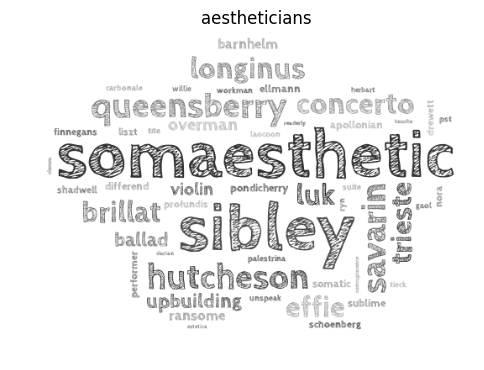

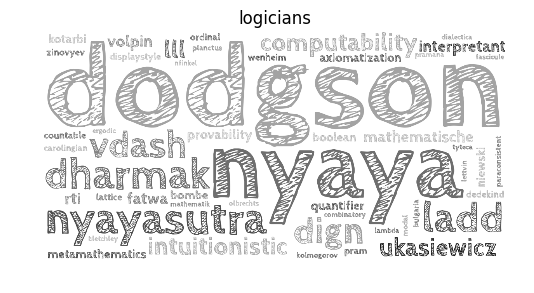

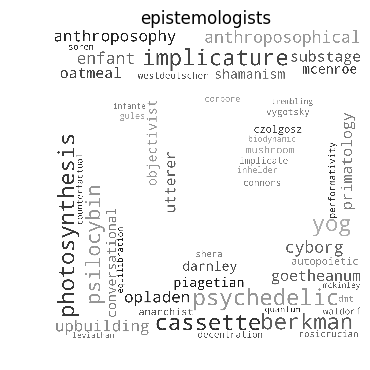

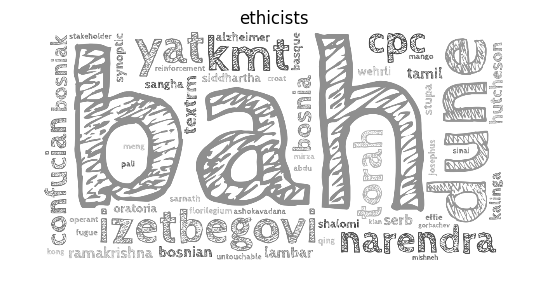

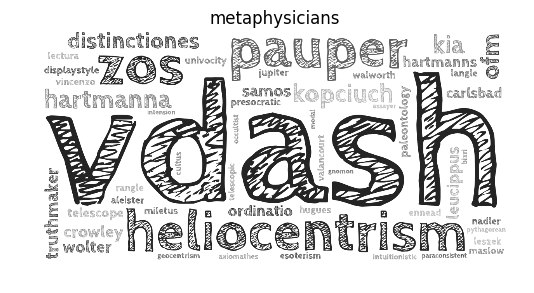

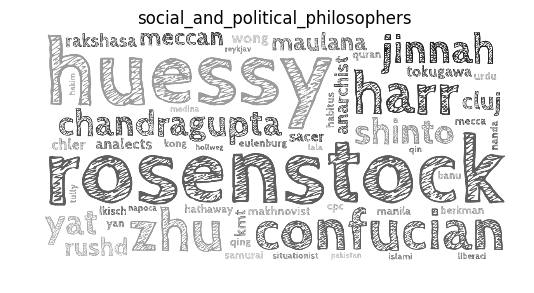

In [26]:
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(10, 70)

# white sufraces are considered masked out
mask1 = imread("img/cloud.png", flatten=True)
mask2 = imread("img/wikipedia.png", flatten=True)

# generate wordclouds
for branch in doc_wordcloud:
    # it is better to save the images with the masks to see something
    # scale, width and height are ignored
    if branch == 'aestheticians':
        wc = WordCloud(
            max_words=50,
            background_color='white',
            font_path='img/CabinSketch-Bold.ttf',
            mask=mask1,
            margin=10).generate(doc_wordcloud[branch])
    elif branch == 'epistemologists':
        wc = WordCloud(
            max_words=50,
            background_color='white',
            mask=mask2,
            margin=10).generate(doc_wordcloud[branch])
    else:
        wc = WordCloud(
            max_words=50,
            background_color='white',
            font_path='img/CabinSketch-Bold.ttf',
            width=1200,
            height=600,
            margin=10).generate(doc_wordcloud[branch])
    # store default colored image
    plt.title(branch)
    plt.imshow(wc.recolor(color_func=grey_color_func, random_state=1))
    plt.axis("off")
    plt.show()

The metaphysicians have the word vdash appearing quite often (very highlighted in the wordcloud) it is also in logicians and actually LaTeX markup for the symbol $\vdash$ ([turnstile symbol](https://en.wikipedia.org/wiki/Turnstile_(symbol) ). This is often used for logical functions. In fact that symbol was first used by [Gottlob Frege](https://en.wikipedia.org/wiki/Gottlob_Frege) in 1879.

Apart from that similarity one can see that all other results contain a lot of different words that sometimes also contain abbreviations like bah, kmt and yat in the ethicists branch that don't make that much sense at first. But BAH stands for Booze Allen Hamilton and even has a [own webiste](http://www.boozallen.com/about/culture-ethics). The origins of Booz Allen’s commitment to culture and ethics trace back to the 1930s, when Carl Hamilton wrote the firm's first formal code of ethics. Thus this is especially referred to only in the ethics branch.

In [20]:
for k in cat:
    if 'Gottlob_Frege' in cat[k]:
        print 'Gottlob_Frege can be found in branch', k

Gottlob_Frege can be found in branch logicians
Gottlob_Frege can be found in branch metaphysicians


# Sentiment Analysis

Sentiment analysis is another highly useful technique. It doesn't tie in strongly with our work on Wikipedia (more on that in the video), but we'll go through it here because experience shows that sentiment analysis might well be very useful when you get to the project stage of the class.

> **Video Lecture**: Uncle Sune talks about sentiment and his own youthful adventures.

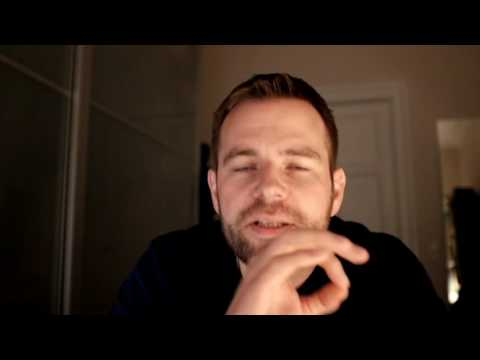

In [30]:
YouTubeVideo("JuYcaYYlfrI",width=800, height=450)

> Reading: [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) 

> Exercise, sentiment over some books from NLPP1e
> 
> * Download the LabMT wordlist. It's available as supplementary material from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) (Data Set S1). Describe briefly how the list was generated.

In [34]:
# get list from website
r = requests.get(
    'http://journals.plos.org/plosone/article/asset?unique&id=info:doi/10.1371/journal.pone.0026752.s001')

In [37]:
# read into pandas dataframe, skip the header
wordlist = pd.read_csv(cStringIO.StringIO(r.text), sep="\t", skiprows=[0, 1])

print wordlist[0:5]

        word  happiness_rank  happiness_average  happiness_standard_deviation  \
0   laughter               1               8.50                        0.9313   
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

  twitter_rank google_rank nyt_rank lyrics_rank  
0         3600          --       --        1728  
1         1853        2458       --        1230  
2           25         317      328          23  
3           65        1372     1313         375  
4         3334        3542       --        2332  


> * Based on the LabMT word list, write a function that calculates sentiment given a list of tokens (the tokens should be lower case, etc). The function should complain if there are no words with sentiment attached.

> * Calculate a sentiment profile for the novels in NLPP1e chapter 1\. The sentiment profile has sentiment on the _y_-axis and position in the text on the _x_-axis. Use a [moving average](https://en.wikipedia.org/wiki/Moving_average) to show how the sentiment changes. Create profiles for sliding windows of length 15 words, 50 words, 100 words, 500 words.

> * Comment on the sentiment profiles. Do they show a similar pattern? What is the effect of changing the size of the sliding window?